In [2]:
# Gerekli kurulumlar
!apt install git-lfs
!git lfs install
!git clone https://huggingface.co/datasets/Densu341/Fresh-rotten-fruit


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
Git LFS initialized.
fatal: destination path 'Fresh-rotten-fruit' already exists and is not an empty directory.


In [3]:

import zipfile

with zipfile.ZipFile("/content/Fresh-rotten-fruit/freshness_fruit.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/freshness_data")


In [4]:
#Hatalı klasör isimlerini düzelt
import os

base_path = "/content/freshness_data/dataset/Test"

rename_map = {
    "freshpatato": "freshpotato",
    "freshtamto": "freshtomato",
    "rottenpatato": "rottenpotato",
    "rottentamto": "rottentomato"
}

for old_name, new_name in rename_map.items():
    old_path = os.path.join(base_path, old_name)
    new_path = os.path.join(base_path, new_name)
    if os.path.exists(old_path):
        os.rename(old_path, new_path)


In [5]:

import shutil

silinecekler = [
    "freshbittergroud", "freshcapsicum",
    "rottenbittergroud", "rottencapsicum"
]

for sinif in silinecekler:
    for split in ["Train", "Test"]:
        klasor = f"/content/freshness_data/dataset/{split}/{sinif}"
        if os.path.exists(klasor):
            shutil.rmtree(klasor)
            print(f"{klasor} silindi.")


/content/freshness_data/dataset/Train/freshbittergroud silindi.
/content/freshness_data/dataset/Train/freshcapsicum silindi.
/content/freshness_data/dataset/Train/rottenbittergroud silindi.
/content/freshness_data/dataset/Train/rottencapsicum silindi.


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (128, 128)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_loader = datagen.flow_from_directory(
    "/content/freshness_data/dataset/Train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_loader = datagen.flow_from_directory(
    "/content/freshness_data/dataset/Test",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

print("✅ Sınıf sayısı:", train_loader.num_classes)


Found 21044 images belonging to 14 classes.
Found 6738 images belonging to 14 classes.
✅ Sınıf sayısı: 14


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(14, activation='softmax')  # 14 sınıf
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,519,630 (24.87 MB)

 Trainable params: 6,519,630 (24.87 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("fresh_14class_model.h5", save_best_only=True, monitor='val_accuracy', verbose=1)

history = model.fit(
    train_loader,
    epochs=10,
    validation_data=val_loader,
    callbacks=[checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5816 - loss: 1.2214
Epoch 1: val_accuracy improved from -inf to 0.84996, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 833s 1s/step - accuracy: 0.5817 - loss: 1.2207 - val_accuracy: 0.8500 - val_loss: 0.3871
Epoch 2/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8384 - loss: 0.4180
Epoch 2: val_accuracy improved from 0.84996 to 0.85738, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 825s 1s/step - accuracy: 0.8384 - loss: 0.4180 - val_accuracy: 0.8574 - val_loss: 0.3293
Epoch 3/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8867 - loss: 0.2849
Epoch 3: val_accuracy improved from 0.85738 to 0.90324, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 857s 1s/step - accuracy: 0.8868 - loss: 0.2849 - val_accuracy: 0.9032 - val_loss: 0.2512
Epoch 4/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9036 - loss: 0.2500
Epoch 4: val_accuracy did not improve from 0.90324
658/658 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - accuracy: 0.9036 - loss: 0.2500 - val_accuracy: 0.8992 - val_loss: 0.2626
Epoch 5/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9194 - loss: 0.2060
Epoch 5: val_accuracy improved from 0.90324 to 0.95325, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - accuracy: 0.9194 - loss: 0.2060 - val_accuracy: 0.9533 - val_loss: 0.1430
Epoch 6/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9416 - loss: 0.1627
Epoch 6: val_accuracy improved from 0.95325 to 0.96572, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 927s 1s/step - accuracy: 0.9415 - loss: 0.1627 - val_accuracy: 0.9657 - val_loss: 0.1144
Epoch 7/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9537 - loss: 0.1310
Epoch 7: val_accuracy did not improve from 0.96572
658/658 ━━━━━━━━━━━━━━━━━━━━ 814s 1s/step - accuracy: 0.9537 - loss: 0.1311 - val_accuracy: 0.9541 - val_loss: 0.1404
Epoch 8/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9551 - loss: 0.1202
Epoch 8: val_accuracy improved from 0.96572 to 0.96972, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 815s 1s/step - accuracy: 0.9551 - loss: 0.1202 - val_accuracy: 0.9697 - val_loss: 0.1001
Epoch 9/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9633 - loss: 0.0991
Epoch 9: val_accuracy improved from 0.96972 to 0.97848, saving model to fresh_14class_model.h5


658/658 ━━━━━━━━━━━━━━━━━━━━ 810s 1s/step - accuracy: 0.9633 - loss: 0.0991 - val_accuracy: 0.9785 - val_loss: 0.0667
Epoch 10/10
658/658 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9660 - loss: 0.0960
Epoch 10: val_accuracy did not improve from 0.97848
658/658 ━━━━━━━━━━━━━━━━━━━━ 813s 1s/step - accuracy: 0.9660 - loss: 0.0960 - val_accuracy: 0.9768 - val_loss: 0.0773


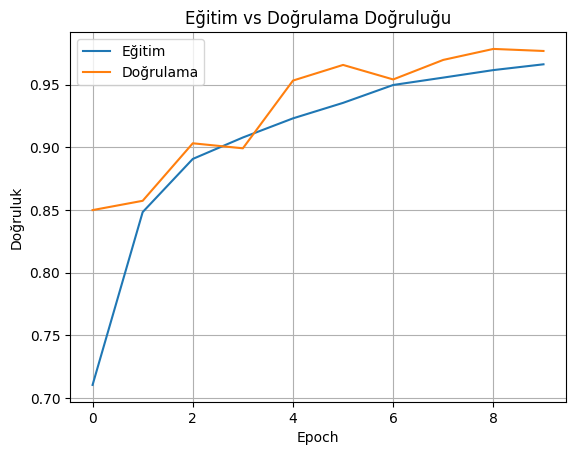

In [9]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.xlabel("Epoch")
plt.ylabel("Doğruluk")
plt.title("Eğitim vs Doğrulama Doğruluğu")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
from google.colab import files
files.download("fresh_14class_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving image.png to image.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


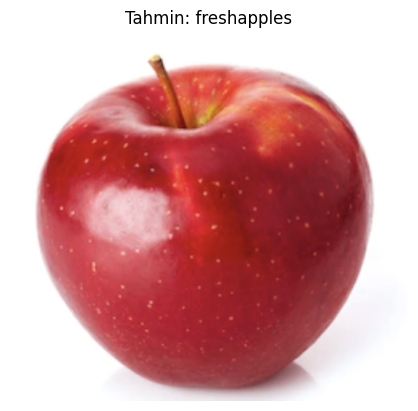

In [19]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Sınıf isimleri sıralı (flow_from_directory sırasına göre)
class_names = ['freshapples', 'freshbanana', 'freshcucumber', 'freshokra', 'freshoranges',
               'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencucumber',
               'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']

model = load_model("fresh_14class_model.h5")

# Kullanıcıdan görsel
from google.colab import files
uploaded = files.upload()


img_path = list(uploaded.keys())[0]
img = Image.open(img_path).convert('RGB')
img_resized = img.resize((128, 128))
img_array = image.img_to_array(img_resized)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Tahmin
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
predicted_label = class_names[predicted_index]

# Sonuçlar
plt.imshow(img)
plt.axis('off')
plt.title(f"Tahmin: {predicted_label}")
plt.show()


In [18]:
import os

train_dir = "/content/freshness_data/dataset/Train"

# Sınıf klasörlerini alfabetik sıraya göre al
class_names = sorted([f for f in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, f))])
print(class_names)


['freshapples', 'freshbanana', 'freshcucumber', 'freshokra', 'freshoranges', 'freshpotato', 'freshtomato', 'rottenapples', 'rottenbanana', 'rottencucumber', 'rottenokra', 'rottenoranges', 'rottenpotato', 'rottentomato']
